# Geospatial ML on the Planetary Computer

⚠️ This is an active area of development. Things are changing relatively quickly here. ⚠️

## Objective: Crop-type prediction

We'll train a model to predict crop types based on [Sentinel-2 L2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) scenes.

Our training *labels* come from the Radiant Earth [South Africa Crop Type Competition](https://registry.mlhub.earth/10.34911/rdnt.j0co8q/). They're a collection of 256 x 256 chips, with integer codes 0-9 indicating the crop type at each pixel in the scene.

## Data access

We'll use STAC for data access. Specifically, we'll interact with two STAC catalogs

1. A static catalog for the labels, hosted in a Blob Storage container
2. The Planetary Computer's STAC API, to query for scenes matching some condition

The overall workflow will be

1. Load a "chip" with the label data (a 256x256 array of integer codes indicate the crop type)
2. Search for and load a scene with Sentinel 2 imagery covering the `labels` chip
3. Transform and crop the (very large) Sentinel 2 scene to match the 256x256 label scene
4. Stack and reshape the data for the machine learning model

In [1]:
import pystac
import pystac_client
import requests
import shapely.geometry
import warnings

warnings.filterwarnings("ignore", "Creating an ndarray from ragged")

### Load labels

We have a STAC catalog of labels for the training data, which is based off the collection used in the Radiant Earth competition.

In [2]:
label_catalog = pystac.read_file(
    "https://esip2021.blob.core.windows.net/esip2021/train/collection.json"
)
label_catalog

<Collection id=ref_south_africa_crops_competition_v1_train_labels>

Each of these label items contains a few thing. They all share the same set of labels: integer codes indicating a particular crop type.

In [3]:
N_SCENES = 50
links = label_catalog.get_item_links()[:N_SCENES]
label_items = [link.resolve_stac_object().target for link in links]

labels = requests.get(label_items[0].assets["raster_values"].href).json()

labels

{'0': 'No Data',
 '1': 'Lucerne/Medics',
 '2': 'Planted pastures (perennial)',
 '3': 'Fallow',
 '4': 'Wine grapes',
 '5': 'Weeds',
 '6': 'Small grain grazing',
 '7': 'Wheat',
 '8': 'Canola',
 '9': 'Rooibos'}

And like any STAC item, they have a specific footprint. Let's plot them on the map.

In [4]:
import geopandas

gdf = geopandas.GeoDataFrame.from_features([x.to_dict() for x in label_items]).set_crs(
    "epsg:4326"
)
m = gdf[["geometry", "datetime"]].explore()
m

Each one of these plots is a (256 x 256) "chip".

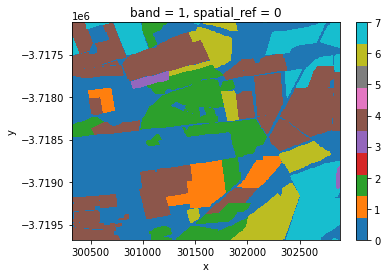

In [5]:
import rioxarray

rioxarray.open_rasterio(label_items[9].assets["labels"].href).squeeze().plot.imshow(
    cmap="tab10"
);

We need to associate the label items with a Sentinel-2 Level 2-A item. We need to find an item that (mostly) covers the field and isn't too cloudy.

We could make one STAC query per label item, but that would be a bit slow and inefficient. Instead, we'll do one search to get all the items covering the bounding box of *all* of our fields. So we need the union of all the bounding boxes.

In [6]:
bbox = tuple(gdf.geometry.total_bounds)
bbox

(17.988104730700773,
 -33.924447667955334,
 19.7366569167977,
 -31.387507094102048)

Now we'll make a search for all the items matching our requirements.

In [7]:
stac_client = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)

date_range = "2017-06-01/2017-09-01"

search = stac_client.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=date_range,
    query={"eo:cloud_cover": {"lt": 25}},
)
sentinel_items = list(search.get_all_items())
len(sentinel_items)

150

So we have bunch of Sentinel 2 items that together cover all of our fields. But these Sentinel scenes are much larger than our fields:

In [8]:
import folium.raster_layers

sentinel_item = sentinel_items[3]

layer = folium.raster_layers.TileLayer(
    tiles=requests.get(sentinel_item.assets["tilejson"].href).json()["tiles"][0],
    attr="Sentinel 2 L2A",
)

layer.add_to(m)
m

So we have a many-to-many relationship: Each Sentinel-2 scene might cover many label chips.  And each label-chip might be coverd by many Sentinel-2 scenes. How do we associate each label chip with exactly one (part of) a Sentinel-2 scene?

That's what we do in the next section. It's a bit complicated, but the basic idea is to pick the least-cloudy Sentinel-2 scene that (mostly) covers our field (at least 90% of it anyway).

In [9]:
def find_match(label_item, sentinel_items):
    # make sure we pick a sentinel scene that
    # 1. overlaps substantially with the label (>90%)
    # 2. minimizes cloud cover
    label_shape = shapely.geometry.shape(label_item.geometry)
    items2 = [
        item
        for item in sentinel_items
        if (
            shapely.geometry.shape(item.geometry).intersection(label_shape).area
            / label_shape.area
        )
        > 0.90
    ]
    sentinel_item = min(
        items2, key=lambda item: pystac.extensions.eo.EOExtension.ext(item).cloud_cover
    )
    return sentinel_item

In [10]:
import planetary_computer

matched = [
    planetary_computer.sign(find_match(label_item, sentinel_items))
    for label_item in label_items
]

One neat point: we've done all this filtering / matching on *metadata*. We haven't actually loaded any data yet. Given the matched `(label_item, sentinel_item)` pairs, we can load in the actual data.

In [11]:
import rioxarray
import stackstac


def load(label_item, sentinel_item):
    label_data = rioxarray.open_rasterio(label_item.assets["labels"].href).squeeze()

    assets = ["B02", "B03", "B04", "B05", "B06", "B07", "B09"]
    data = (
        stackstac.stack(
            sentinel_item.to_dict(),
            assets=assets,
            epsg=label_data.rio.crs.to_epsg(),  # reproject to the labels' CRS
            bounds=label_data.rio.bounds(),  # crop to the labels' bounds
            resolution=10,  # resample all assets to the highest resolution
            dtype="float32",
            fill_value=0,
        )
        .squeeze()
        .assign_coords(
            y=lambda ds: (ds.y - 5).round(),  # fix half-pixel label issue
            x=lambda ds: (ds.x + 5).round(),
        )
        .compute()
    )

    assert data.shape[1:] == label_data.shape

    # Add a label_id dimension, to track which training data goes with
    # which pixels. This will be helpful later on in evaluation.
    data = data.expand_dims({"label_id": [label_item.id]})
    label_data = label_data.expand_dims({"label_id": [label_item.id]})

    return data, label_data

We're actually loading data now. This will take a bit of time.

In [12]:
%%time
Xs, ys = zip(
    *[
        load(label_item, sentinel_item)
        for label_item, sentinel_item in zip(label_items, matched)
    ]
)

CPU times: user 7.82 s, sys: 579 ms, total: 8.4 s
Wall time: 16.4 s


In [13]:
Xs[0].shape

(1, 7, 256, 256)

Now we have a list of DataArrays, each with the dimensions `(label_id, band, y, x)`. We'll use Scikit-Learn to train the model, which expects a 2-D array with dimensions `(observations, features)`. In this case, an "observation" is a single pixel (the pixel at coordinate `(-3717125, 274725)` for example), and the features are the 7 bands.

So we need to reshape each DataArray from size `(1, 7, 256, 256)` to `(65536, 7)` and then concatenate them all vertically.

In [14]:
import xarray as xr

X = xr.concat([x.stack(pixel=("label_id", "y", "x")).T for x in Xs], dim="pixel")
y = xr.concat([y.stack(pixel=("label_id", "y", "x")) for y in ys], dim="pixel")

assert X.indexes["pixel"].equals(y.indexes["pixel"])

In [15]:
X.shape

(3276800, 7)

In [16]:
y.shape

(3276800,)

Thanks to xarray's indexing, we can easily go from these stacked DataArray back to a plot.

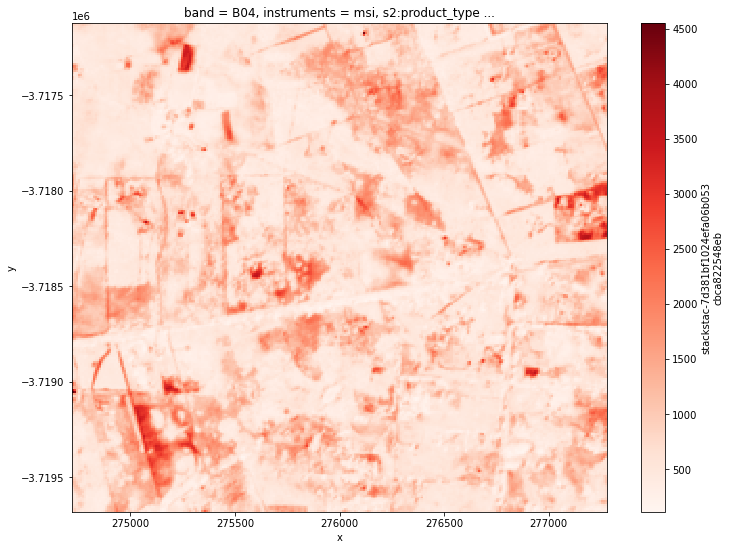

In [17]:
label_id = label_items[0].id
X.sel(label_id=label_id).unstack().sel(band="B04").plot(cmap="Reds", figsize=(12, 9));

## Train the model

Now that we've done all the pre-processing, we can train the actual model.

We'll start with a scikit-learn KNeighborsClassfier ([User Guide](https://scikit-learn.org/stable/modules/neighbors.html#classification), [API Reference](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) to establish a baseline model for this dataset.

In [18]:
import sklearn.neighbors
import sklearn.model_selection

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

In [20]:
clf = sklearn.neighbors.KNeighborsClassifier()
%time clf.fit(X_train, y_train)

CPU times: user 7.66 s, sys: 57 ms, total: 7.72 s
Wall time: 7.72 s


KNeighborsClassifier()

Training score:

In [21]:
%time clf.score(X_train[::100], y_train[::100])

CPU times: user 4.52 s, sys: 0 ns, total: 4.52 s
Wall time: 4.52 s


0.8660481770833334

Test score:

In [22]:
%time clf.score(X_test[::100], y_test[::100])

CPU times: user 1.53 s, sys: 0 ns, total: 1.53 s
Wall time: 1.53 s


0.8055419921875

Plot the first field.

In [23]:
label_id = label_items[0].id

x = X.sel(label_id=label_id)
predictions = clf.predict(x)
actual = y.sel(label_id=label_id).unstack()

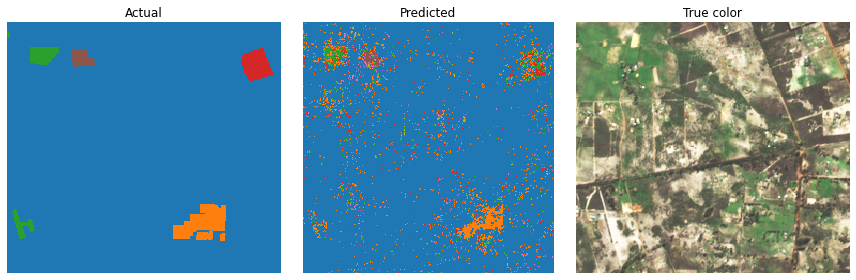

In [24]:
import matplotlib.pyplot as plt
import xrspatial.multispectral

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))

actual.plot(x="x", y="y", cmap="tab10", ax=ax1, add_colorbar=False, vmin=0, vmax=10)
ax2.imshow(predictions.reshape(256, 256), cmap="tab10", vmin=0, vmax=10)

xrspatial.multispectral.true_color(
    *x.unstack("pixel").sel(band=["B04", "B03", "B02"])
).plot.imshow(ax=ax3, add_colorbar=False)

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()

ax1.set(title="Actual")
ax2.set(title="Predicted")
ax3.set(title="True color")
plt.tight_layout()

So we do OK at differentiating "field" from "not a field". We don't seem to do as well at predicting the actual crop type. We also have a lot of "speckling".

## Recap

We were able to train a basic ML model to predict crop types from Sentinel-2 satellite imagery. We used STAC to find and load our data, xarray to reshape the data into an appropriate form for the model, and scikit-learn to train the model.